Spark Dataframes and SQL
--------------------------

Wine quality dataset from: https://archive.ics.uci.edu/ml/datasets/Wine+Quality

Loading a DataFrame from a csv file:

In [41]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true', delimiter=';')\
    .load('spark-data/winequality-white.csv')

Exploring data using Data Frame.

In [42]:
df.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [43]:
df.count()

4898

In [44]:
df.limit(5).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [45]:
df.groupby('quality').max().toPandas()

,quality,max(fixed acidity),max(volatile acidity),max(citric acid),max(residual sugar),max(chlorides),max(free sulfur dioxide),max(total sulfur dioxide),max(density),max(pH),max(sulphates),max(alcohol),max(quality)
0,3,11.8,0.640,0.47,16.20,0.244,289.0,440.0,1.00010,3.55,0.74,12.6,3
1,4,10.2,1.100,0.88,17.55,0.290,138.5,272.0,1.00040,3.72,0.87,13.5,4
2,5,10.3,0.905,1.00,23.50,0.346,131.0,344.0,1.00241,3.79,0.88,13.6,5
3,6,14.2,0.965,1.66,65.80,0.255,112.0,294.0,1.03898,3.81,1.06,14.0,6
4,7,9.2,0.760,0.74,19.25,0.135,108.0,229.0,1.00040,3.82,1.08,14.2,7
5,8,8.2,0.660,0.74,14.80,0.121,105.0,212.5,1.00060,3.59,0.95,14.0,8
6,9,9.1,0.360,0.49,10.60,0.035,57.0,139.0,0.99700,3.41,0.61,12.9,9


In [46]:
df.groupby('quality').avg('pH', 'alcohol').show()

+-------+------------------+------------------+
|quality|           avg(pH)|      avg(alcohol)|
+-------+------------------+------------------+
|      3|            3.1875|            10.345|
|      4|3.1828834355828226|10.152453987730064|
|      5|3.1688332189430386| 9.808840082361012|
|      6|3.1885987261146482|10.575371549893838|
|      7|3.2138977272727285|11.367935606060609|
|      8|3.2186857142857117|11.635999999999997|
|      9|             3.308|             12.18|
+-------+------------------+------------------+



Exploring data using SQL.

In [47]:
df.registerTempTable('wine')
sqlContext.sql("SELECT quality, avg(alcohol) AS avg_alcohol FROM wine GROUP BY quality").show()

+-------+------------------+
|quality|       avg_alcohol|
+-------+------------------+
|      3|            10.345|
|      4|10.152453987730064|
|      5| 9.808840082361012|
|      6|10.575371549893838|
|      7|11.367935606060609|
|      8|11.635999999999997|
|      9|             12.18|
+-------+------------------+



Let's visualise data using PCA for dimensionality reduction

In [48]:
data = sqlContext.sql("SELECT *, CAST(quality AS DOUBLE) AS label FROM wine")
data.cache()

DataFrame[fixed acidity: double, volatile acidity: double, citric acid: double, residual sugar: double, chlorides: double, free sulfur dioxide: double, total sulfur dioxide: double, density: double, pH: double, sulphates: double, alcohol: double, quality: int, label: double]

In [49]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import PCA
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline


all_assembler = VectorAssembler(
    inputCols=["sulphates", "density", "alcohol"],
    outputCol="features")
normalizer = Normalizer(inputCol="features", outputCol="norm_features")
pca = PCA(k=2, inputCol="norm_features", outputCol="pca_features")

pca_pipeline = Pipeline(stages=[all_assembler, normalizer, pca])

pca_model = pca_pipeline.fit(data)

pca_model.transform(data).first()

Row(fixed acidity=7.0, volatile acidity=0.27, citric acid=0.36, residual sugar=20.7, chlorides=0.045, free sulfur dioxide=45.0, total sulfur dioxide=170.0, density=1.001, pH=3.0, sulphates=0.45, alcohol=8.8, quality=6, label=6.0, features=DenseVector([0.45, 1.001, 8.8]), norm_features=DenseVector([0.0507, 0.1129, 0.9923]), pca_features=DenseVector([-0.013, -0.0169]))

In [50]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


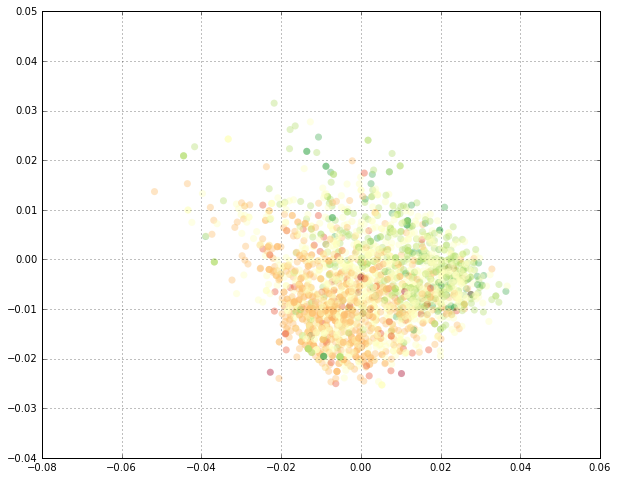

In [51]:
import matplotlib.pyplot as plt
pca_data = pca_model.transform(data)

sampling_fraction = 0.5

pca_xy = np.matrix(map(lambda r:r.pca_features.array, pca_data.sample(False, sampling_fraction, 13).collect()))
pca_colors = map(lambda r: float(r.quality),data.select('quality').sample(False, sampling_fraction, 13).collect())

plt.scatter(pca_xy[:,0], pca_xy[:,1], c=pca_colors, alpha=0.4, cmap=plt.get_cmap('RdYlGn'), edgecolors='none', s=50)
plt.grid(True)
plt.show()